In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

## Raster Geometry

Performant access to geospatial raster data is a crutial task involving coordinate to pixel index transformations or georeferencing image data. Such a task is completely independent from the data values themselves, and can solely work with the 6 affine geotransformation parameters (https://gdal.org/user/raster_data_model.html), a spatial reference system (cf. `SpatialRef`), and the dimentions of a raster image.  

The geospatial representation of a raster image has been realised with the class `RasterGeometry`, which is available within the `raster` module of `geospade`.

### Initialisation

The constructor of `RasterGeometry` expects the following arguments:

- `n_rows`: Number of rows or height in pixels of the raster
- `n_cols`: Number of columns or width in pixels of the raster
- `sref`: A spatial reference system represented by an instance of `SpatialRef`
- `geotrans` (optional): tuple containing the 6 GDAL affine geotransformation parameters
- `geom_id` (optional): ID of the raster geometry
- `description` (optional): Verbal description of the raster geometry
- `px_origin` (optional): The world system origin of the pixels (cf. Properties section).
- `parent` (optional): Parent raster geometry (important after operations which modify the properties of this raster geometry)

How the 6 geotransformation parameters relate to a georeferenced raster can be seen in the figure below. 

<img src="../imgs/geotrans_params.png" width="400" style="float: center;">

In [2]:
from geospade.crs import SpatialRef
from geospade.raster import RasterGeometry

# initialisation of variables
n_rows = 50
n_cols = 50
sref = SpatialRef(4326)
geotrans = (5, 0.2, 0, 50, 0, -0.2) # ul_x, x_pixel_size, x_rot, ul_y, y_rot, y_pixel_size
geom_id = "Tile 1"
# additional, optional parameters: geom_id, description, px_origin, parent
raster_geom = RasterGeometry(n_rows, n_cols, sref, geotrans=geotrans, geom_id=geom_id)

This is not the only way to create a raster geometry. You can also initialise a raster geometry from a given extent, 

In [3]:
extent = [5, 40, 15, 50]
raster_geom_ext = RasterGeometry.from_extent(extent, sref, 0.2, 0.2)

from a given OGR geometry, 

In [4]:
from osgeo import osr
from osgeo import ogr
from shapely.geometry import Polygon

polygon = Polygon([(5, 40), (5, 50), (15, 50), (15, 40), (5, 40)])
ogr_geom = ogr.CreateGeometryFromWkt(polygon.wkt)
ogr_geom.AssignSpatialReference(sref.osr_sref)

raster_geom_poly = RasterGeometry.from_geometry(ogr_geom, 0.2, 0.2)

from other raster geometries, i.e. creating a raster geometry containing all other raster geometries,

In [5]:
geotrans_l = (5, 0.2, 0, 50, 0, -0.2)
raster_geom_l = RasterGeometry(n_rows, 25, sref, geotrans=geotrans_l)
geotrans_r = (10, 0.2, 0, 50, 0, -0.2)
raster_geom_r = RasterGeometry(n_rows, 25, sref, geotrans=geotrans_r)

raster_geom_mrg = RasterGeometry.from_raster_geometries([raster_geom_l, raster_geom_r])

or finally from a human-readable, JSON-like definition:

In [6]:
import json

json_str = """
{
    "id": null,
    "number_of_rows": 50,
    "number_of_columns": 50,
    "spatial_reference": {
        "proj": "longlat",
        "datum": "WGS84",
        "no_defs": true
    },
    "geotransformation": [
        5.0,
        0.2,
        0,
        50.0,
        0,
        -0.2
    ],
    "pixel_origin": "ul",
    "description": ""
}
"""
definition = json.loads(json_str)
raster_geom_def = RasterGeometry.from_definition(definition)

All options above result in the same raster geometry object.

As a last use-case, we can initialise a raster geometry from a rotated, rectangular geometry. This object will be relevant in the next chapters.

In [7]:
from shapely import affinity
# rotate boundary by 45°
boundary_rot = affinity.rotate(raster_geom.boundary_shapely, 45, 'center')
geom_rot = ogr.CreateGeometryFromWkt(boundary_rot.to_wkt())
geom_rot.AssignSpatialReference(sref.osr_sref)

raster_geom_rot = RasterGeometry.from_geometry(geom_rot, 0.2, 0.2, geom_id="ROTATED")

### Properties

Now having a raster geometry instance ready, we can continue with inspecting the properties of this object. 
The shape of the geometry is defined by its width  

In [8]:
raster_geom.width

50

and its height.

In [9]:
raster_geom.height

50

Direct shape access is possible with (height, width)

In [10]:
raster_geom.shape

(50, 50)

The same can be done by using actual world system coordinates. The width is accessable through

In [11]:
raster_geom.x_size

10.0

and the height through

In [12]:
raster_geom.y_size

10.0

The sizes of each pixel can be easily retrieved via

In [13]:
raster_geom.x_pixel_size

0.2

and 

In [14]:
raster_geom.y_pixel_size

0.2

In the case of a rotated raster geometry there additional properties, which can be of interest, for instance the counter-clockwise orientation in radians with respect to the W-E direction/horizontal.

In [15]:
raster_geom_rot.ori

-0.7853981633974482

You can also check if your raster geometry is rotated or not with

In [16]:
raster_geom.is_axis_parallel, raster_geom_rot.is_axis_parallel

(True, False)

A very important thing of the relationship between pixel and world system coordinates is the anchor point or pixel origin, i.e. to what point in the pixel the coordinate refers to. By default the GDAL definition is used, which states that the origin is in the upper-left corner of the upper-left pixel. But with a raster geometry, you also have the option to choose between all other corner points and the pixel center. 

The aformentioned properties and the different possibilities for the pixel origin are illustrated in the graphic below.

<img src="../imgs/raster_geometry.png" width="600" style="float: center;">

If you are interested in the corner points of the raster geometry, several properties help you to access the respective coordinates. For example, the lower-left corner, i.o.w. the first pixel in the last row, has the following coordinates:

In [17]:
raster_geom.ll_x, raster_geom.ll_y

(5.0, 40.2)

If you want to know the full coordinate extent (x_min, y_min, x_max, y_max), you can call

In [18]:
raster_geom.coord_extent

(5.0, 40.2, 14.8, 50.0)

Please note that all these coordinates refer to the pixel origin, which has been chosen during class initialisation.
If you are interested in the full extent of the raster geometry (bold black line in the image before), you can use

In [19]:
raster_geom.outer_boundary_extent

(5.0, 40.0, 15.0, 50.0)

The corner points of the outer boundary are available via

In [20]:
raster_geom.outer_boundary_corners

[(5.0, 40.0), (5.0, 50.0), (15.0, 50.0), (15.0, 40.0)]

Note that they match `outer_boundary_extent` only for non-rotated raster geometries, but not for rotated ones. The full range of 1-D coordinates in a certain direction along the edges of a raster geometry can be retrieved with 

In [21]:
raster_geom.x_coords

array([ 5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7. ,
        7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,
        9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4,
       11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6,
       13.8, 14. , 14.2, 14.4, 14.6, 14.8])

and 

In [22]:
raster_geom.y_coords

array([50. , 49.8, 49.6, 49.4, 49.2, 49. , 48.8, 48.6, 48.4, 48.2, 48. ,
       47.8, 47.6, 47.4, 47.2, 47. , 46.8, 46.6, 46.4, 46.2, 46. , 45.8,
       45.6, 45.4, 45.2, 45. , 44.8, 44.6, 44.4, 44.2, 44. , 43.8, 43.6,
       43.4, 43.2, 43. , 42.8, 42.6, 42.4, 42.2, 42. , 41.8, 41.6, 41.4,
       41.2, 41. , 40.8, 40.6, 40.4, 40.2])

These coordinates only refer to the first row or first column. They are representatives for the whole raster geometry in the non-rotated case, but not as soon as we are working with a rotated raster geometry. As an example, the former allows to use these two properties as input to e.g., `numpy.meshgrid`, to create a 2-D array of coordinates.

The boundary of the raster geometry is also availabe on a higher-level, e.g. as a WKT string, OGR or shapely geometry.

In [23]:
raster_geom.boundary_wkt

'POLYGON ((5 40,5 50,15 50,15 40,5 40))'

Not all properties have been discussed here. Please take look at the documentation to explore the full range of offered functionality.

### Plotting

A very nice feature of a raster geometry is that you can plot it on a map. Several keywords can help you to beautify your plot. First, we can simply try to plot the raster geometry we have created before.

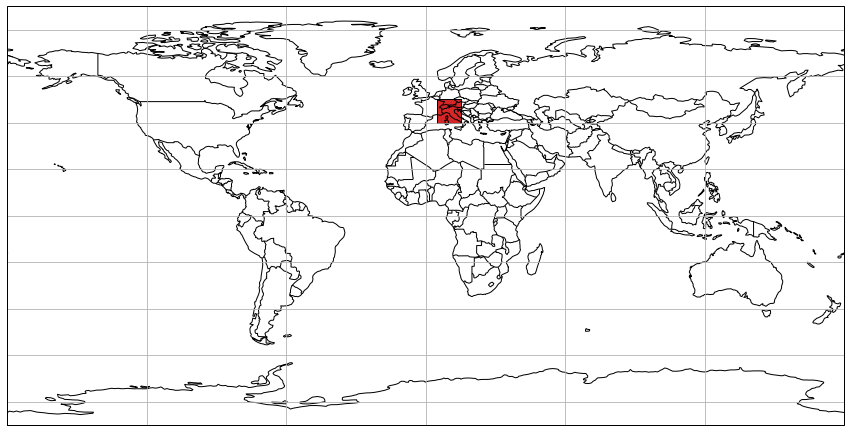

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
raster_geom.plot()

Since the full extent of the projection is chosen by default, we can try limit the extent with:

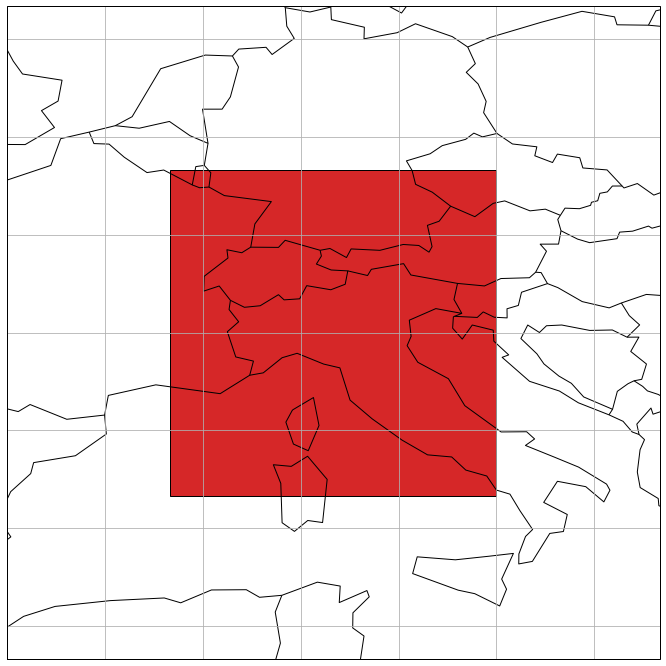

In [25]:
plt.figure(figsize=(12, 12))
raster_geom.plot(extent=[0, 35, 20, 55])

The style of the raster geometry can be modified too. In the following example we are now using the rotated geometry again.

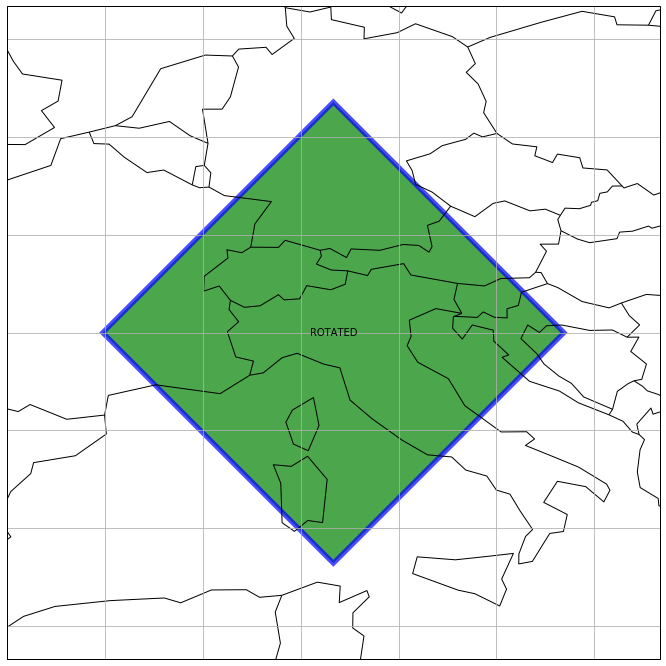

In [26]:
plt.figure(figsize=(12, 12))
raster_geom_rot.plot(label_geom=True, facecolor='green', edgecolor='blue', edgewidth=5, alpha=.7, extent=[0, 35, 20, 55])

The plot function also allows to change the projection. We can try to define a new one, e.g. a Pseudo-Mercator projection, with the help of the `SpatialRef` class and use it for our new map.

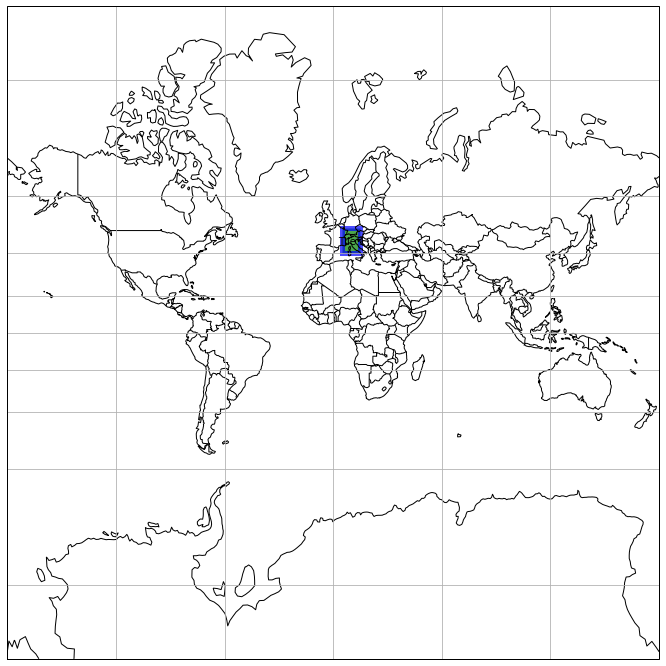

In [27]:
mercator_proj = SpatialRef(3857).to_cartopy_proj()

plt.figure(figsize=(12, 12))
raster_geom.plot(label_geom=True, facecolor='green', edgecolor='blue', edgewidth=5, alpha=.7, 
                proj=mercator_proj)

### Topological Operations

Raster geometries provide the functionality to interact with each other or with other geometries. The first set of functions checks for certain topological constrains, e.g. WITHIN, INTERSECTS, TOUCHES or OVERLAPS. To try this out we can create additional raster geometries.  

In [28]:
geotrans_within = (6, 0.2, 0, 49, 0, -0.2)
raster_geom_within = RasterGeometry(25, 25, sref, geotrans=geotrans_within, geom_id="WITHIN")

geotrans_outer = (1, 0.2, 0, 49, 0, -0.2)
raster_geom_outer = RasterGeometry(15, 5, sref, geotrans=geotrans_outer, geom_id="OUTER")

geotrans_overlap = (12, 0.2, 0, 45, 0, -0.2)
raster_geom_overlap = RasterGeometry(15, 30, sref, geotrans=geotrans_overlap, geom_id="OVERLAPS")

geotrans_touch = (10, 0.2, 0, 40, 0, -0.2)
raster_geom_touch = RasterGeometry(35, 25, sref, geotrans=geotrans_touch, geom_id="TOUCHES")

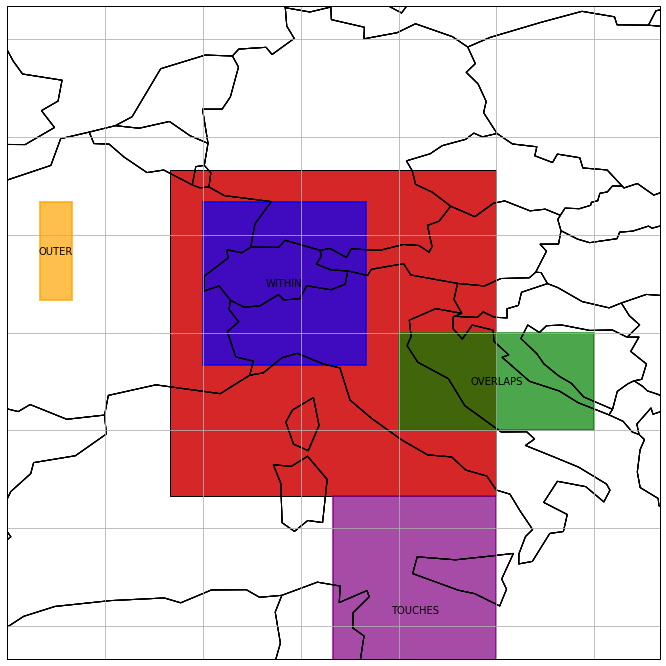

In [29]:
plt.figure(figsize=(12, 12))
ax_1 = raster_geom.plot(extent=[0, 35, 20, 55])
raster_geom_within.plot(ax=ax_1, label_geom=True, facecolor='blue', edgecolor='blue', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])
raster_geom_outer.plot(ax=ax_1, label_geom=True, facecolor='orange', edgecolor='orange', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])
raster_geom_overlap.plot(ax=ax_1, label_geom=True, facecolor='green', edgecolor='green', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])
raster_geom_touch.plot(ax=ax_1, label_geom=True, facecolor='purple', edgecolor='purple', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])

In [30]:
raster_geom_within.within(raster_geom), raster_geom_within.intersects(raster_geom), raster_geom_within.touches(raster_geom), raster_geom_within.overlaps(raster_geom)

(True, True, False, False)

In [31]:
raster_geom_outer.within(raster_geom), raster_geom_outer.intersects(raster_geom), raster_geom_outer.touches(raster_geom), raster_geom_outer.overlaps(raster_geom)

(False, False, False, False)

In [32]:
raster_geom_overlap.within(raster_geom), raster_geom_overlap.intersects(raster_geom), raster_geom_overlap.touches(raster_geom), raster_geom_overlap.overlaps(raster_geom)

(False, True, False, True)

In [33]:
raster_geom_touch.within(raster_geom), raster_geom_touch.intersects(raster_geom), raster_geom_touch.touches(raster_geom), raster_geom_touch.overlaps(raster_geom)

(False, True, True, False)

### Modifying a Raster Geometry

Several functions allow to not only interact with other (raster) geometries, but also to modify the existing raster geometry, or to create a new one. The first set of methods represents an intersection with the raster geometry, either by using a second geometry (`slice_by_geom`) or by using a pixel window (`slice_py_pixels`).

Lets try the former operation by using the previously created "OVERLAPS" raster geometry.

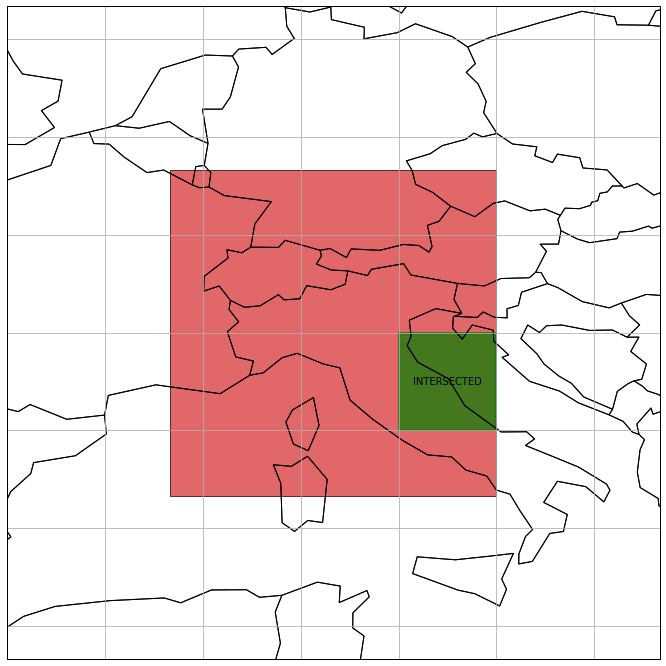

In [34]:
raster_geom_intsct = raster_geom.slice_by_geom(raster_geom_overlap, inplace=False, geom_id="INTERSECTED")

plt.figure(figsize=(12, 12))
ax = raster_geom.plot(alpha=.7, extent=[0, 35, 20, 55])
raster_geom_intsct.plot(ax=ax, label_geom=True, facecolor='green', edgecolor='green', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])

You can also create a new, arbitrary polygon and use it to intersect it with the raster geometry:

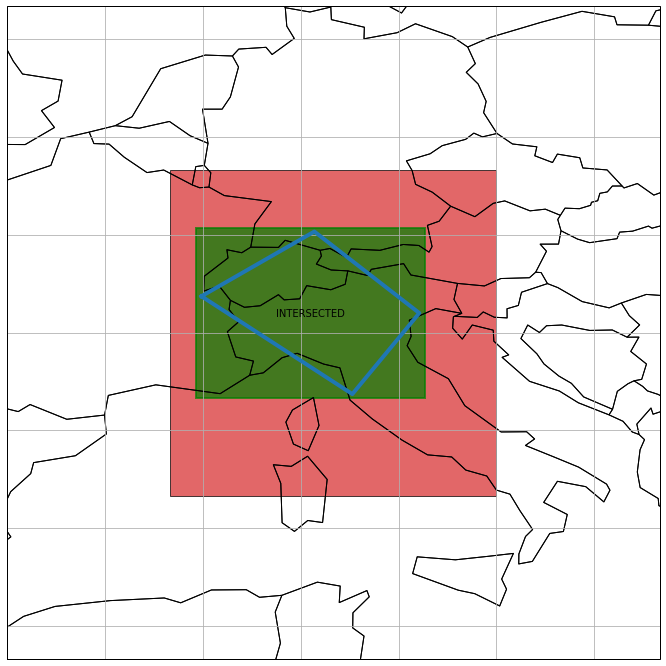

In [35]:
polygon = Polygon([(5.9552, 46.1152), (9.4171, 48.0995), (12.6352, 45.6005), (10.5818, 43.1164), (5.9552, 46.1152)])
x_coords, y_coords = polygon.exterior.xy
ogr_geom = ogr.CreateGeometryFromWkt(polygon.to_wkt())
ogr_geom.AssignSpatialReference(sref.osr_sref)

raster_geom_intsct = raster_geom.slice_by_geom(ogr_geom, inplace=False, geom_id="INTERSECTED")

plt.figure(figsize=(12, 12))
ax = raster_geom.plot(alpha=.7, extent=[0, 35, 20, 55])
raster_geom_intsct.plot(ax=ax, label_geom=True, facecolor='green', edgecolor='green', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])
ax.plot(x_coords, y_coords, linewidth=4)

Since a raster geometry is also defined in pixel dimensions, one can use `slice_by_rc` to cut out a region of interest.

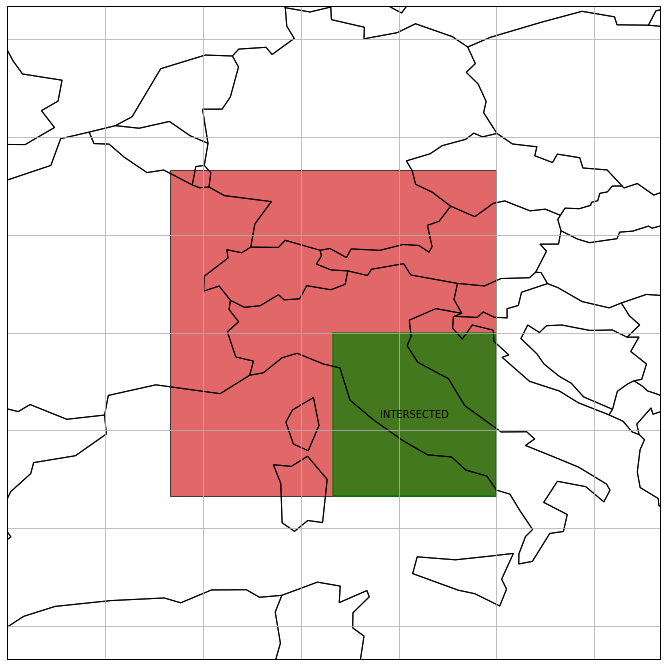

In [36]:
raster_geom_intsct = raster_geom.slice_by_rc(25, 25, height=100, width=100, inplace=False, geom_id="INTERSECTED")

plt.figure(figsize=(12, 12))
ax = raster_geom.plot(alpha=.7, extent=[0, 35, 20, 55])
raster_geom_intsct.plot(ax=ax, label_geom=True, facecolor='green', edgecolor='green', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])

In addition, you can change the size of the raster geometry. This can be for instance done in a homogeneous manner by specifying a scale factor to shrink the geometry

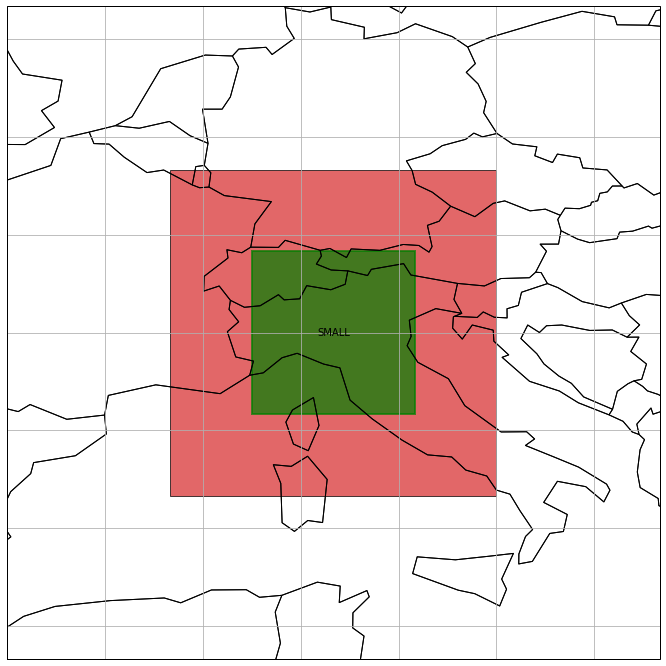

In [37]:
raster_geom_small = raster_geom.scale(0.5, geom_id='SMALL')

plt.figure(figsize=(12, 12))
ax = raster_geom.plot(alpha=.7, extent=[0, 35, 20, 55])
raster_geom_small.plot(ax=ax, label_geom=True, facecolor='green', edgecolor='green', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])

or to enlarge it

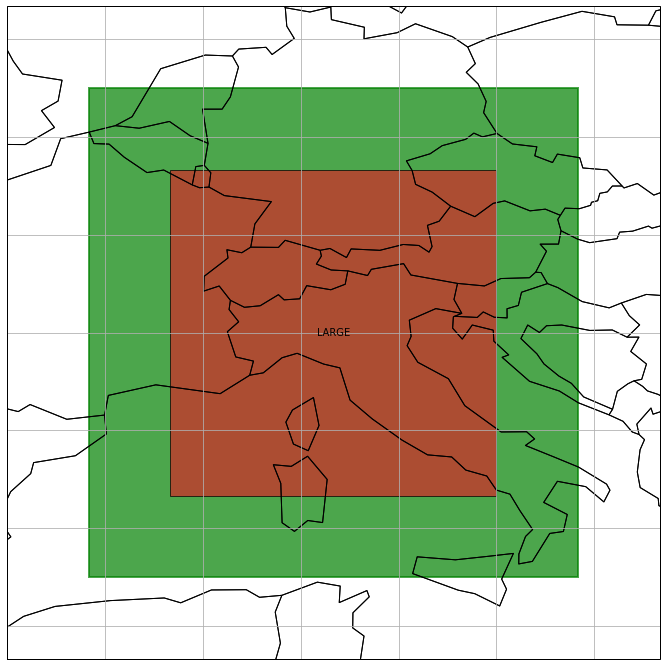

In [38]:
raster_geom_large = raster_geom.scale(1.5, geom_id='LARGE')

plt.figure(figsize=(12, 12))
ax = raster_geom_large.plot(label_geom=True, facecolor='green', edgecolor='green', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])
raster_geom.plot(ax=ax, alpha=.7, extent=[0, 35, 20, 55])

If you want to be more specific and resize the raster geometry along one of its edges, you can use `resize` to set a scale_factor (`''`), a pixel buffer (`'px'`) or a coordinate buffer (`'sr'`) for each edge. 

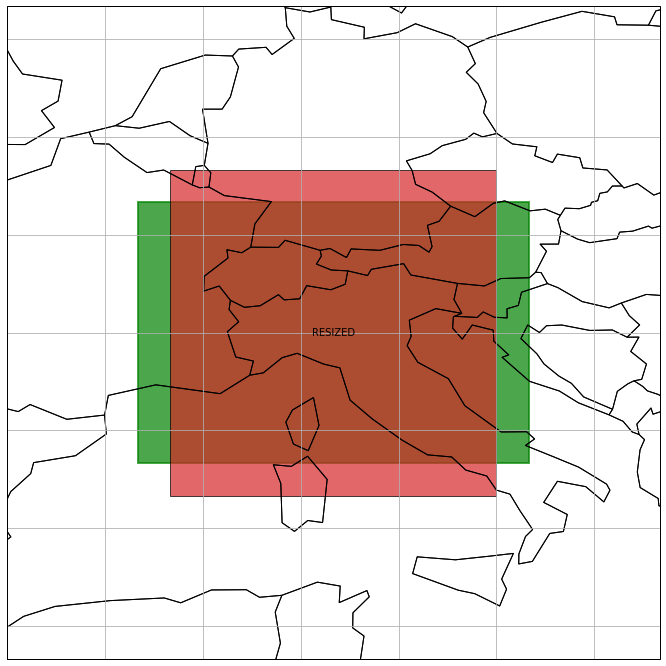

In [39]:
# the buffers need to be specified in clock-wise order, starting with the left edge
coord_buffer = [1., -1., 1., -1.]
raster_geom_res = raster_geom.resize(coord_buffer, unit='sr', geom_id='RESIZED')

plt.figure(figsize=(12, 12))
ax = raster_geom_res.plot(label_geom=True, facecolor='green', edgecolor='green', edgewidth=2, alpha=.7, extent=[0, 35, 20, 55])
raster_geom.plot(ax=ax, alpha=.7, extent=[0, 35, 20, 55])

### Coordinate Conversions

A raster geometry also provides an interface for pixel to coordinate (`rc2xy`) and coordinate to pixel (`xy2rc`) conversions. 

In [40]:
import numpy as np

rows, cols = np.meshgrid(np.arange(25, 30), np.arange(0, 25))
x_coords, y_coords = raster_geom.rc2xy(rows.flatten(), cols.flatten())
x_coords, y_coords

(array([5. , 5. , 5. , 5. , 5. , 5.2, 5.2, 5.2, 5.2, 5.2, 5.4, 5.4, 5.4,
        5.4, 5.4, 5.6, 5.6, 5.6, 5.6, 5.6, 5.8, 5.8, 5.8, 5.8, 5.8, 6. ,
        6. , 6. , 6. , 6. , 6.2, 6.2, 6.2, 6.2, 6.2, 6.4, 6.4, 6.4, 6.4,
        6.4, 6.6, 6.6, 6.6, 6.6, 6.6, 6.8, 6.8, 6.8, 6.8, 6.8, 7. , 7. ,
        7. , 7. , 7. , 7.2, 7.2, 7.2, 7.2, 7.2, 7.4, 7.4, 7.4, 7.4, 7.4,
        7.6, 7.6, 7.6, 7.6, 7.6, 7.8, 7.8, 7.8, 7.8, 7.8, 8. , 8. , 8. ,
        8. , 8. , 8.2, 8.2, 8.2, 8.2, 8.2, 8.4, 8.4, 8.4, 8.4, 8.4, 8.6,
        8.6, 8.6, 8.6, 8.6, 8.8, 8.8, 8.8, 8.8, 8.8, 9. , 9. , 9. , 9. ,
        9. , 9.2, 9.2, 9.2, 9.2, 9.2, 9.4, 9.4, 9.4, 9.4, 9.4, 9.6, 9.6,
        9.6, 9.6, 9.6, 9.8, 9.8, 9.8, 9.8, 9.8]),
 array([45. , 44.8, 44.6, 44.4, 44.2, 45. , 44.8, 44.6, 44.4, 44.2, 45. ,
        44.8, 44.6, 44.4, 44.2, 45. , 44.8, 44.6, 44.4, 44.2, 45. , 44.8,
        44.6, 44.4, 44.2, 45. , 44.8, 44.6, 44.4, 44.2, 45. , 44.8, 44.6,
        44.4, 44.2, 45. , 44.8, 44.6, 44.4, 44.2, 45. , 44.8, 44.6, 44.

In [41]:
rows, cols = raster_geom.xy2rc(x_coords, y_coords)
rows, cols

(array([25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26,
        27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28,
        29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25,
        26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27,
        28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29,
        25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26,
        27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28, 29, 25, 26, 27, 28,
        29, 25, 26, 27, 28, 29]),
 array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
         6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
        10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
        13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
        17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19

### Magic Methods

For some of the aforementioned functions a set of magic methods are available to enable a Pythonic usage of a raster geometry. This involves for instance the WITHIN check, which is internally called when using Pythons `in`.

In [42]:
raster_geom_within in raster_geom, raster_geom_outer in raster_geom

(True, False)

Similar to `SpatialRef`, also here comparison operators are provided. Two raster geometries are considered (spatially) the same if they have the same outer boundary corners, number of rows and number of cols.

In [43]:
raster_geom == raster_geom_poly, raster_geom == raster_geom_rot

(True, False)

The `&` operator makes use of the `slice_by_geom` method.

In [44]:
raster_geom_intsct = raster_geom.slice_by_geom(ogr_geom, inplace=False)
raster_geom_intsct2 = raster_geom & ogr_geom
raster_geom_intsct == raster_geom_intsct2

True

The `str` method returns the WKT representation of the raster geometry.

In [45]:
str(raster_geom)

'POLYGON ((5 40,5 50,15 50,15 40,5 40))'

Finally, you can use brackets with two or three items to subset the raster geometry. Two items are interpreted as pixel slices, e.g. `[min_row:max_row, min_col:max_col]`, and three items yield intersection by coordinates, where the third item is a spatial reference instance, e.g. `[min_x:max_x, min_y:max_y, SpatialRef(4326)]`.

In [46]:
raster_geom_intsct = raster_geom.slice_by_rc(25, 25, height=100, width=100, inplace=False)
raster_geom_intsct2 = raster_geom[25:50, 25:50]
raster_geom_intsct == raster_geom_intsct2

True

In [47]:
min_x, max_yp1 = raster_geom.rc2xy(25, 25)
max_xp1, min_y = raster_geom.rc2xy(50, 50)
raster_geom_intsct3 = raster_geom[min_x:max_xp1, min_y:max_yp1, sref]
raster_geom_intsct == raster_geom_intsct3

True

Note that in the examples above the pixel index (50, 50) is already outside the raster geometry. This is because slicing is also performed as usual in Python, i.e. the "stop" value of the slice is excluded.  